## we will derive and implement the diffusion process. We will use MNIST dataset to build a diffusion model to generate digits.

We will start with variational autoencoders 

$$
\log p_\theta(x)  \geq \sum_{q_\phi(z|x)} \log p_\theta(x|z) - KL(q_\phi(z|x) || p_\theta(z))
$$

The detailed derivation is given in the VAE notebook. 

In diffusion model, we will consider decoder as forward process and encoder as reverse process. we will consider latent variable z as x at different timesteps t=1,2,3...T and observed variable as x_0.

$$
\log p_\theta(x_{0})  \geq \sum_{q_\phi(x_{1:T}|x_{0})} \log p_\theta(x_{0:T}|x_{0}) - KL(q_\phi(x_{1:T}|x_{0}) || p_\theta(x_{1:T}|x_{0}))
$$

The detailed derivation is given [here](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/deep_dive_into_ddpms.ipynb)

I m writing the final equations used in this notebook 

## linear beta schedule 

we have $\beta_{min}$ and $\beta_{max}$ as min and max values of beta. 

$$
\beta_{t} = \beta_{min} + (t/T) * (\beta_{max} - \beta_{min})
$$

Forward process is defined as 

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_{t}}x_{t-1}, \beta_{t}I)
$$


$$
x_t = \sqrt{1-\beta_{t}}x_{t-1} + \sqrt{\beta_{t}} \epsilon_{t}
$$

where $\epsilon_{t}$ is standard normal noise. 

Using reparametrization trick we can write treat $\alpha_{t}$ as 1-$\beta_{t}$, so after serveral steps of derivations we get $x_{t}$ in terms of $x_{0}$ as 

$$
x_t = \sqrt{\bar{\alpha}_{t}} x_0 + \sqrt{1-\bar{\alpha}_{t}} \epsilon_{t}
$$

where $\bar{\alpha}_{t} = \prod_{i=1}^{t} \alpha_{i}$ and $\alpha_{i} = 1-\beta_{i}$


while training in reverse process we will use $x_{t-1}$ in terms of $x_{t}$ and $\epsilon_{t}$

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} (x_{t} - \frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \epsilon_{t}) + \beta_{t} z
$$

where z is standard normal noise and $\epsilon_{t}$ is noise in forward process which is predicted by a deep learning model.

The loss function is defined as 

$$
L = \mathbb{E}_{x_0, \epsilon} [|| \epsilon - \epsilon_\theta(x_t, t) ||^2]
$$

where $\epsilon$ is noise added in forward process and $\epsilon_\theta$ is noise predicted by the model.



In [5]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

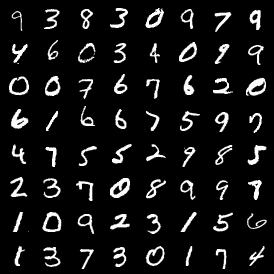

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8))

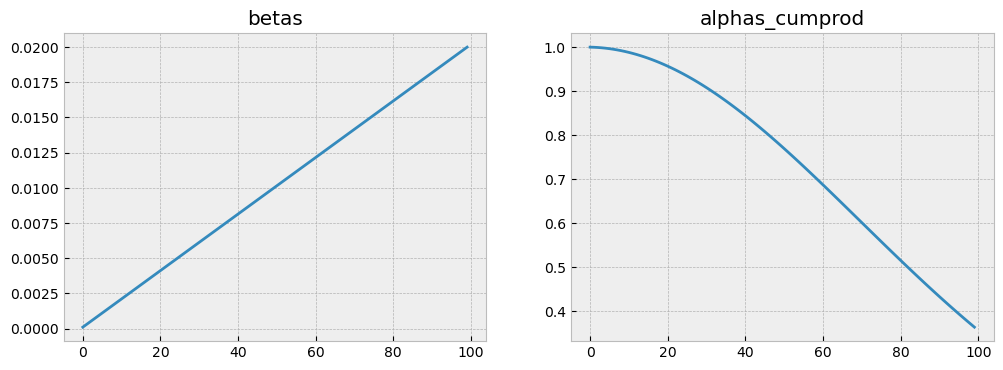

In [12]:
## Lets add some noise to the images using linear beta schedule  
T = 100 #usually 1000 but since MNIST is small we can use 100
beta_min = 0.0001
beta_max = 0.02
betas = torch.linspace(beta_min, beta_max, T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax.flat[0].plot(betas)
ax.flat[1].plot(alphas_cumprod)
ax.flat[0].set_title('betas')
ax.flat[1].set_title('alphas_cumprod')
plt.show()



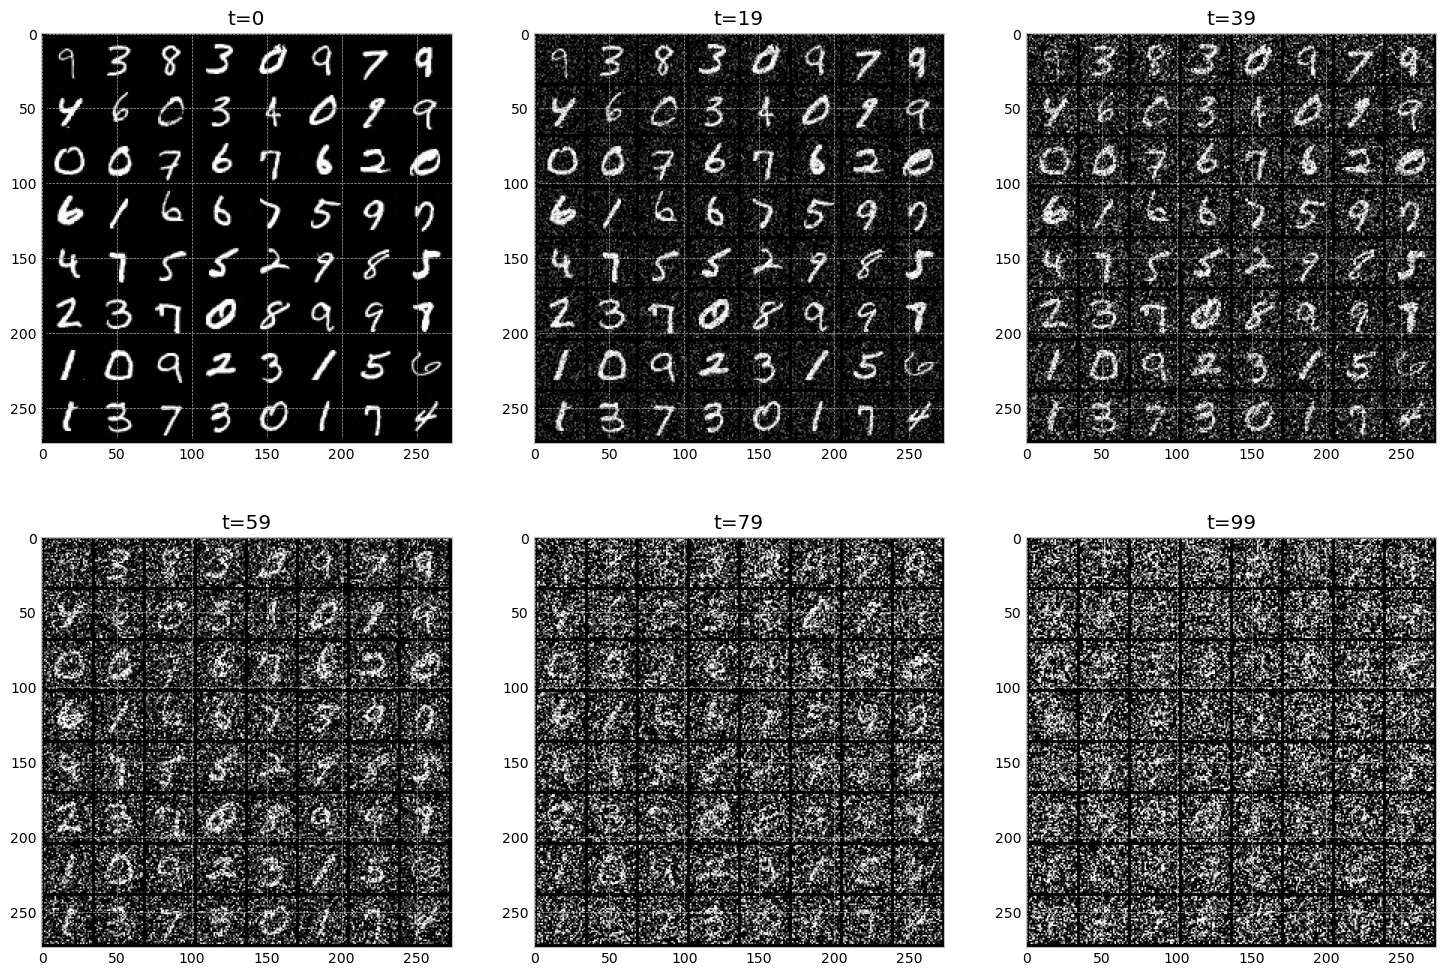

In [14]:
# Lets visualize the forward process T = 0, 20, 40, 60, 80, 100
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, i in enumerate([0, 19, 39, 59, 79, 99]):
    xt = torch.sqrt(alphas_cumprod[i]) * imgs + torch.sqrt(1 - alphas_cumprod[i]) * torch.randn_like(imgs)
    xt = xt.clamp(0, 1)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt, nrow=8))
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={i}')
plt.show()